# Jacobian Accumulation for Machine Learning

## Introduction
In computer science we are given a (possibly differentiable) function $f\colon \mathcal{R}^n \to \mathcal{R}^m$ and we want to compute it's Jacobian:

\begin{equation}
F'(x) = D_x f(x) \subset \mathcal{R}^{m \times n}
\end{equation}

AD provides an exact procedure for computing the Jacobian $F'(x)$ up to machine precision.
To do so, we evaluate $f$ via an eval routine $\bf{eval}(x,y)$ that represent $f$ onto a tape as a combination of independent variables $\mathcal{X}$, intermediate variables $\mathcal{P}$ and dependent variables $\mathcal{Y}$, related via intermediate simple functions $\psi$.

The generalized evaluation procedure can be summarized in the following table:

| $v$ | $idx$ | $\text{group}$|
| -------- | -------- | -------|
| $v_{j} = x_j$     | $j=1 \dots n$     | $\mathcal{X}$|
| $v_j = \psi_{j}(v_i)_{i \prec j}$     | $j=n+1 \dots n+p$     | $\mathcal{P}$|
| $y_{j}=v_{j}$     | $j=n+p+1 \dots  n+p+m$     | $\mathcal{Y}$|

For  agiven node $v_j$ the operator $\prec$ resolve the dependecies for $\psi_j$ in the set of parents $\mathcal{P}_j$, where the set of indexes $\mathcal{P}_j \subset \{1 \dots j-1\}$.
The  $v_j = \psi(v_i)_{i \in P_j}$ are called $\textbf{elemental functions}$ which we assume to be well defined and have a jointly continous partial derivative, the $\textbf{elemental partials}$, at $x\in \mathcal{R}^n$:

\begin{equation}
c_{ji}(v_i)_{i \in \mathcal{P}_j} = D_{v_i} \phi_j \quad \text{for} \ i \in \mathcal{P}_j
\end{equation}

In the following section we attempt to recover the reverse and forward mode AD by accumulating the elemental partials.

#### Forward AD
Suppose, $x$ is a function of some parameter and denote $x' \subset \mathcal{R}^{n}$ as the tangent vector, then $\forall \ i > n$ we have:

\begin{equation}
Dv_j = \sum_{i \in P_j} c_{ji} \cdot Dv_i \quad\in \ \mathcal{R}
\end{equation}

It's possible to show the iterative application for every $j=n, \dots, n+p+m$ of the equation above leads to $Dy = F'(x)Dx$.

The time complexity of computing the total Jacobian $F'(x)$ is given by:
\begin{equation}
    \textrm{time}\{F'(x)\} \leq \beta \hat{n} \ \text{time}\{F(x)\}
\end{equation}

Where $\hat{n}$ is the $\bf{min}$ between $n$ and the max of non-zeros entries in any rows of $F'(x)$.
The constant $\beta$ depends on the immediate cost of updating the sensitivies in place from the elemental partials.
#### Reverse AD
Often time is convenient to accumulate Jacobians in reverse mode, which for $m=1$, yields gradients at fixed cost relative to the evaluation of the function but are more storage intesive.

Define the successor set as $\mathcal{S}_i \subset \{ i < j \leq n + m + p \mid i \in \mathcal{P}_j\}$ and the adjoint as:
\begin{equation}
\hat{v}_i = \sum_{j\in S_i} c_{ji} \cdot \hat{v}_j \quad \in \mathcal{R}
\end{equation}

Where the scalar quantities $\hat{v}_i = D_{v_i}\hat{y}^\top \cdot f(x)$ are the sensitivies.
As for the forward mode, the recursive application of the equation above with $i=n+p+m \dots  n+1$ is equivalent of $\hat{x}^\top = \hat{y}^\top F'(x)$.

The time complexity of computing the total Jacobian is given by:
\begin{equation}
\text{time}\{F'(x)\} \leq \beta \hat{m} \ \text{time}\{F(x)\}
\end{equation}

Where $\hat{m}$ is the $\bf{min}$ between $m$ the max non-zeros in any columns of $F'$.

#### Time complexity
It is clear that for both reverse mode and forward mode AD, the time complexity is upperbounded by a multiple of the time of evaluating the function $f$, which depends on the number of elemental function visited in the evaluation procedure. The question that we now try to ask is the following:

Is it possible to reduce the time complexity of $F'(x)$ by changing the order of accumulation of the elemental partials?



#### Vertex Elimination
The intermediate variables $v_j$ can be encoded as a computational graph $\mathcal{G} = \langle \mathcal{V}, \mathcal{E} \rangle$.
Where  $\mathcal{V}=\langle\mathcal{X}, \mathcal{P}, \mathcal{Y}\rangle$ and a set of edges $\mathcal{E}$ representing each dependency, $i \to j$, when $i \in \mathcal{P}_j$, that is the variable $v_j$ depends on $v_i$.

Each edge represents a depedency with the elementary partial $c_{ji}$ as mulipliers. The linearized graph $\mathcal{G}$ is acyclical, by construction. If the graph $\mathcal{P}=\emptyset$ is bipartite and its edges are the non zero entries in the Jacobian matrix.

Vertex elimination proposes to sequentially eliminate each vertex without altering the relation between $Dx, Dy$. 

##### Elimination
Eliminating $v_j$ is equivalent of eliminating $Dv_j$ from $Dv_k = \sum_{j \in \mathcal{P}_k} c_{kj} Dv_j$, for all $k \in S_j$.
\begin{align}
D v_k &= c_{kj} \cdot Dv_j + \sum_{i \in P_k \setminus j} c_{ki} \cdot Dvi \\
      &= \sum_{i \in \mathcal{J}} c_{kj} \cdot c_{ji} \cdot Dv_j+ \sum_{i \in P_k \setminus j} c_{ki} \cdot Dvi \\
      &= \sum_{\mathcal{P}_j \cup P_k \setminus j} \tilde{c}_{ki} \cdot Dv_i
\end{align}
Then set $\tilde{c}_{ki} = c_{ki} + c_{kj} \cdot c_{ji}$, $c_{ki} = 0 \ \text{if}  \ i \notin \mathcal{P}_k$ and repeat  the same process for every $i \in S_i$.

The number of multiplication required to eliminate $v_j$ involves:
\begin{equation}
m(v_j) = \mid \mathcal{P}_j \mid \cdot \mid \mathcal{S}_j\mid
\end{equation}

where $\mid \cdot \mid$ is the cardinality of the set.
Note that each elimination alter the Markovitz degree of its parents and its children. 

Note that Vertex Elimination may recover, Forward mode and Reverse mode, by selecting the elimination path $j={n+1, \dots, n+p}$ and $j={n+p, \dots, n+1}$ respectively.

##### Relation with Bauer Formula
During the elimination process, each edge $l \to k$ may have $c_{kl}$ which depends upon the elimination ordering. If $c_{kl}$ is direct, that is there are no intermediate vertexes on the path $l \to k$ then it's value is an entry of the Jacobian $F'(x)$, and it satisifes:
\begin{equation}
c_{kl} = \sum_{\mathcal{J}\colon l \to k} \prod_{i,j} c_{ij}
\end{equation}

The set of paths $\mathcal{J} = \{l, j_1, \dots, j_i, \dots, k\}$, of the original entries the (elemental partials).

#### Vertex Elimination to Markov Decision Process
We now cast VE as a  Markov Decision Process.
VE starts with an initial graph $\mathcal{G}$ where the set of intermediates nodes $\mathcal{P}\neq \emptyset$ and terminates when $\mathcal{P}=\emptyset$. Let $\{\mathcal{G}_t,t=0 \dots T\}$ be the sequence of graphs generated by the VE procedure with $\mathcal{G}_T \colon \mathcal{P} =\emptyset$.
At every decision stage $t$, an algorithm selects an intermediate vertex $v_j \in \mathcal{P}_t$. A simulator apply the VE rules for the $v_j$ and return a new graph $\mathcal{G}_{t+1}$, and a total reward of $r_t$.

The final graph $\mathcal{G}_T$ is bipartite, the set of edges $\mathcal{E}_T$ contains the multiplicative weight for each direct edge $x \to y$, and thus, the Jacobian $F'_T(x)$.

In practice the states $\mathcal{S}$ are the edge matrix $\mathcal{E} \subset \mathcal{R}^{\mid \mathcal{V} \mid \times \mid \mathcal{V} \mid }$, the set of actions $\mathcal{A}_s$ as the set of remaining intermediate nodes at decision time $\mathcal{P}_t$, and the deterministic transition dynamics $f(s_t, a_t)$ as described in the VE section.
The cost function is the number of fill-in edges after the elmination of the j-th vector, which encodes the total number of operations left.
The Markovi

```python
for child, parent in itertools.product(*[out_edge, in_edge]):
    while True:
        try:
            self._edges.remove((key, child))
        except ValueError:
            break
    while True:
        try:
            self._edges.remove((parent, key))
        except ValueError:
            break
    self._edges.append((parent, child))
```

#### MCTS
Monte Carlo Tree Search is a randomized search algorithm that given an initial state and a simulator, it returns the values for each legal actions at the given state. 
The standard UCT implementation fits our use case, but we need to accomodate dense rewards.

```python
for n in range(n_simulations):
    simulator.set_state(s)
    last_state, path = select(root, simulator)
    value = evaluate(last_state)
    backpropagate(path, value)
```

To do so, we replace the state value of the ith node $v_i = \sum_{k>i} r_k$ of each node obtained by the evaluate procedure by adding the immediate reward, $v_i = \sum_{k\geq i} r_k = r_i + v_{i+1}$, and modify the backpropagation routine accordingly:

```python
def backpropagate(path: List\[Node\], value: float):  
    for node in reversed(path):  
        node.total_reward = value  
        node.explore_count += 1  
        value = node.reward + value
```
The complete algorithm reads as follows:
```python
# get a new graph and set of intermediate vertices
G, done, legal_actions = env.reset() 
while not done:
    # estimate values for each action
    root = mcts.search(G, simulator, legal_actions)
    # apply greedy action
    G, done, legal_actions = env.step(root.greedy_action())
    # get a new graph according to VE rules
```
### Experiments

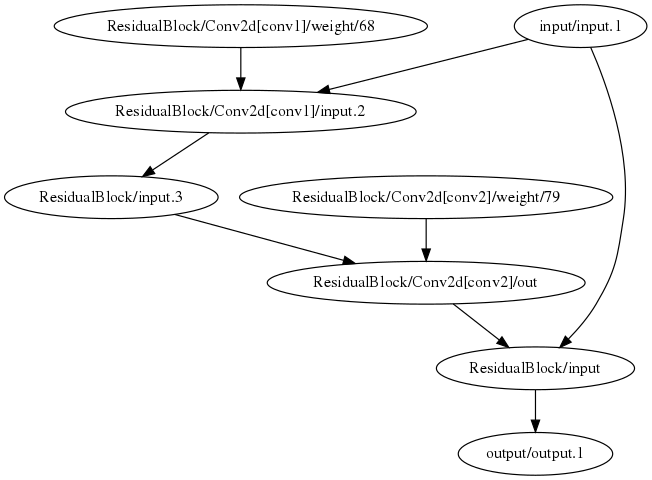

In [1]:
from env import make_graph
from utils import operation_count
from IPython.display import Image
Image(filename = "assets/graph_1.png", width = 600, height = 300)
# input_size = (1,1,1,1) [B, C, H, W]
# output_size = (1,1,1,1)

In [2]:
graph = make_graph()
edges = graph.get_connectivity()
print("Shape edge matrix:", edges.shape)

Shape edge matrix: (9, 9)


In [3]:
print("Total operation count:", operation_count(edges))

Total operation count: 28


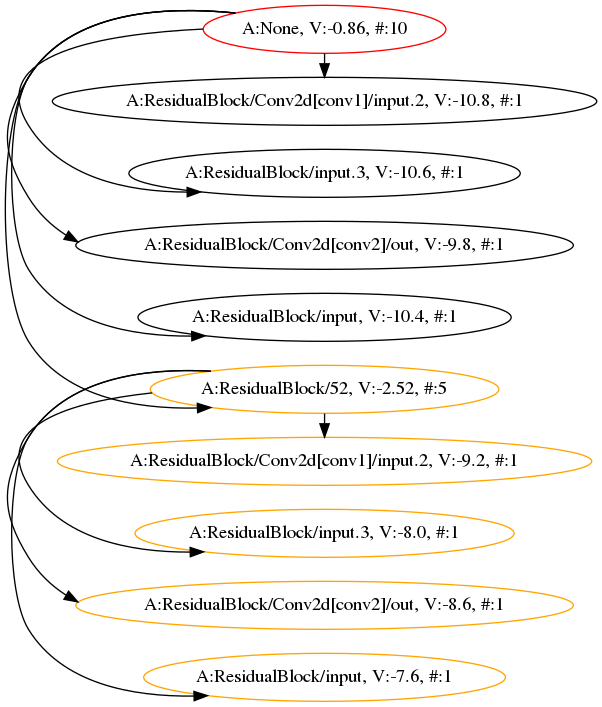

In [4]:
# MCTS result for the inital graph
Image(filename = "assets/mcts_5.png", width = 600, height = 300)

In [5]:
from env import Env
from mcts import Evaluator, mcts


class config:
    num_simulations = 10
    num_rollouts = 5
    uct_c = 1.25


def main():
    env = Env()
    simulator = Env()
    evaluator = Evaluator(game=simulator, n_rollouts=config.num_rollouts)
    state, _, done, info = env.reset()
    actions = []
    assert info["pa"]
    total_reward = 0
    t = 0
    while not done:
        action = mcts(env.get_state(), simulator, evaluator, config).best_child().action
        state, reward, done, info = env.step(action)
        total_reward += reward
        # env.render()
        print(info)
        t += 1
        actions.append(action)
    print(total_reward)
    
main()

bwd op count: 28
bwd op count: 28
Please install graphviz to get the MCTS plot.
{'pa': ['ResidualBlock/Conv2d[conv1]/input.2', 'ResidualBlock/input.3', 'ResidualBlock/Conv2d[conv2]/out', 'ResidualBlock/input'], 'adds': 1.0, 'del': 2.0}
Please install graphviz to get the MCTS plot.
{'pa': ['ResidualBlock/Conv2d[conv1]/input.2', 'ResidualBlock/input.3', 'ResidualBlock/Conv2d[conv2]/out'], 'adds': 2.0, 'del': 3.0}
Please install graphviz to get the MCTS plot.
{'pa': ['ResidualBlock/Conv2d[conv1]/input.2', 'ResidualBlock/Conv2d[conv2]/out'], 'adds': 1.0, 'del': 2.0}
Please install graphviz to get the MCTS plot.
{'pa': ['ResidualBlock/Conv2d[conv1]/input.2'], 'adds': 2.0, 'del': 3.0}
Please install graphviz to get the MCTS plot.
{'pa': [], 'adds': 2.0, 'del': 3.0}
-8.0


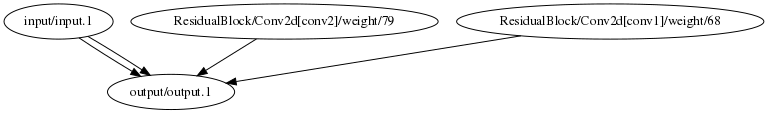

In [6]:
Image(filename = "assets/graph_5.png", width = 600, height = 300)

### Discussion
OJA is known to be NP-hard. A sub-problem of OJA is Vertex Elimination which, in some cases, promises to reduce the computational cost of Jacobian accumulation. We cast VE as an MDP and apply UCT to find an accumulation path that minmizes the total number of multiplication.
Preliminary results shows a reduction of 2/3 in number of operation, for a simple resnet block. 
Contrary to Reverse Mode AD, VE access the "tape" in a non sequential order, which complicates the application of checkpointing.

In this experiments we use a random evaluator to guide the search MCTS algorithm. It is natural to wonder if it's possible to learn an evaluator aligned with the machine learning objective, and how to combine this tecnique with dropout / pruning.